# Deep Q Learning to Play Space Invaders

In [1]:
# Import packages
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
import random
import time

from tensorflow.keras.models import Sequential
import tensorflow as tf

from skimage import transform 
from skimage.color import rgb2gray 

## [1] Create the environment

In [2]:
# Create our environment
env = gym.make("SpaceInvaders-v0")

# Get state and action space
state_size = env.observation_space
action_size = env.action_space.n

print("The size of our frame is: ", state_size)
print("The action size is : ", action_size)

The size of our frame is:  Box(210, 160, 3)
The action size is :  6


## [2] Preprocess Functions

In [3]:
# plotting the images in a list
def plot_frames(display_list, title_list = None):
    
    plt.figure(figsize=(10, 10))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1) 
        
        if title_list:
            plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

### [2.1] Image Filtering

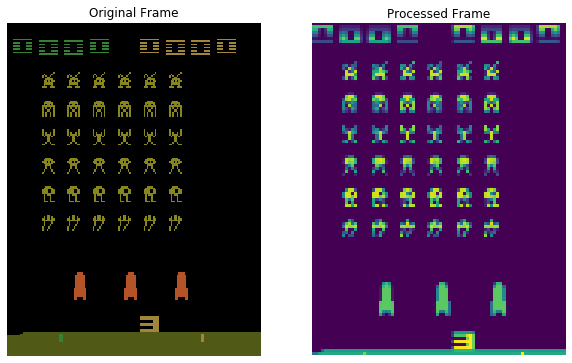

Size before process:  (210, 160, 3)
Size after process:  (110, 84)


In [4]:
# Normalise, turn into greyscale and crop image
frame_size = (110, 84)
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, frame_size)
    
    return preprocessed_frame # 110x84x1 frame

# Test out the preprocess procedure
sample_state = env.reset()
sample_state_processed = preprocess_frame(sample_state)
plot_frames([sample_state, sample_state_processed], ['Original Frame','Processed Frame'])

print('Size before process: ', sample_state.shape)
print('Size after process: ', sample_state_processed.shape)

### [2.2] Stack the frames

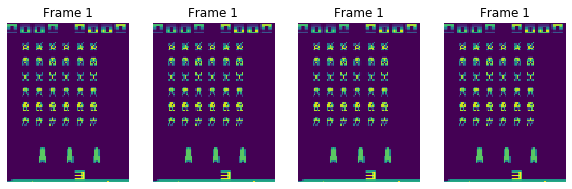

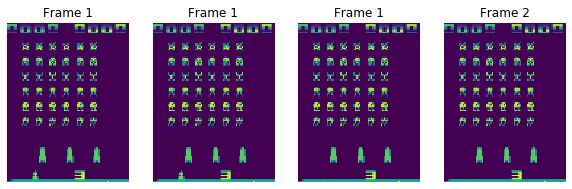

In [5]:
# Given a stacked frame, append a new frame to this stack
def stack_frames(stacked_frames, new_frame, is_new_episode):
    
    # Preprocess frame before stacking
    frame = preprocess_frame(new_frame)
    
    # if new episode make copies of frame, else append frame
    if is_new_episode:
        
        # Clear stacked frames
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        
        # Append the same frame to the stack stack_size times
        for _ in range(0, stack_size):
            stacked_frames.append(frame)
        
        # Return a numpy array for the stacked frame
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    else:
        stacked_frames.append(frame)
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    return stacked_states, stacked_frames

# Stacking frames to provide input = [frame 1, frame 2, frame 3, frame 4]
stack_size = 4

# Initialise with array of zeros
stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)

# Test out the stack_frames procedure
sample_state = env.reset()
stacked_states, stacked_frames = stack_frames(stacked_frames, sample_state, True)
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(0,4)])

for i in range(0, 4):
    sample_next_state, _ , done , _  = env.step(env.action_space.sample())
    stacked_states, stacked_frames = stack_frames(stacked_frames, sample_next_state, False)
    
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(1,4)] + ['Frame 2'] )

## 3 Training 

In [7]:
# Define paramters for training 
LEARNING_RATE = 0.001
MEMORY_SIZE = 1000000
BATCH_SIZE = 64
MAX_STEP = 50000

EXPLORATION_RATE = 1
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.1

GAMMA = 0.9

### [3.1] Create Deep Q Neural Network

In [8]:
# Define Q-Learning Nerual Network Model
model = Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(8,8), strides=(4,4), activation='relu', input_shape=(110, 84, 4)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu')) 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(action_size, activation='linear'))
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 9, 64)         32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 736,934
Trainable params: 736,934
Non-trainable params: 0
__________________________________________________

### [3.2] Create memory for experience relay

In [ ]:
# Create a memery storage 
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

### [3.3] Act to exploit or explore

In [10]:
# Function to pick action either from model or take random action
def act(state, exploration_rate):
    
    # Take random action
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    
    # Else use the model to predict a action
    q_values = model.predict(state[tf.newaxis,...])
    
    return np.argmax(q_values[0])

## [3.4] Train agent in batches from memory

In [11]:
# Function to fit data from experience obtained from memory, THE LEARNING PROCEDURE
def model_fit(BATCH_SIZE):
    
    # Sample from memory
    batch = memory.sample(BATCH_SIZE)

    # Initialise list of target Q and states
    target_Q = []
    state_train = []

    # Extract each parameter from batch
    for state, action, reward, state_next, done in batch:

        # add states to list
        state_train.append(state)

        # Add the target Q to list
        if done:
            Q_values = model.predict(state[tf.newaxis,...])
            Q_values[0][action] = reward
            target_Q.append(Q_values[0])
        else:
            Q_values = model.predict(state[tf.newaxis,...])
            Q_values[0][action] = reward + GAMMA * np.max(model.predict(state_next[tf.newaxis,...])[0])
            target_Q.append(Q_values[0])

    # turn states and target Q in numpy arrays
    state_train = np.array(state_train)
    target_Q = np.array(target_Q)
    
    # Fit the data 
    history = model.fit(state_train, target_Q, verbose = 0)
    
    return history

### [3.5] Test agent by taking random actions

In [12]:
# Initialise memory
memory = Memory(MEMORY_SIZE)

# Play a game to test environment 
def test(n_episodes, model = None, memory = None):
    
    # Initialise average rewards
    avg_rewards = 0
    run_list = []
    
    for i in range(1, n_episodes+1):
        
        # Initialise the start of environment
        state = env.reset()
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        done = False 
        total_reward = 0
        steps = 0

        while not done:
            if model:
                action = np.argmax(model.predict(state[tf.newaxis,...])[0])
            else:
                action = env.action_space.sample()
            state_next, reward, done, info = env.step(action)
            state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)
            if memory:
                memory.add((state, action, reward, state_next, done))
            state = state_next
            total_reward += reward
            steps += 1
            if steps > MAX_STEP:
                done = True
        
        avg_rewards = avg_rewards + 1/(i) * (total_reward - avg_rewards)
        run_list.append(steps)
        
    return run_list, avg_rewards

steps, total_reward = test(1, model = None, memory = memory)

print("Total steps by taking random actions: ", steps)
print("Total rewards by taking random actions: ", total_reward)
print("Memory length: ", len(memory.buffer))

Total steps by taking random actions:  [744]
Total rewards by taking random actions:  125.0
Memory length:  744


In [69]:
# Check time taken to train for 1 batch
start_time = time.time()
history = model_fit(BATCH_SIZE)
print("Loss is :", history.history['loss'][0])
print("Elapsed_time: ", time.time() - start_time)

Loss is : 0.6375454664230347
Elapsed_time:  2.3583829402923584


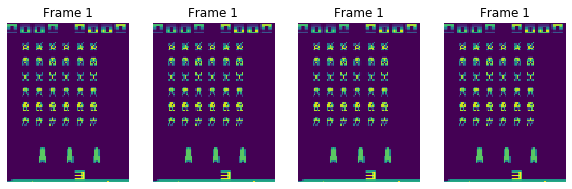

In [13]:
state, action, reward, state_next, done = memory.buffer[0]
plot_frames([state[:,:,i] for i in range(0,4)], ['Frame ' + str(1) for i in range(0,4)])

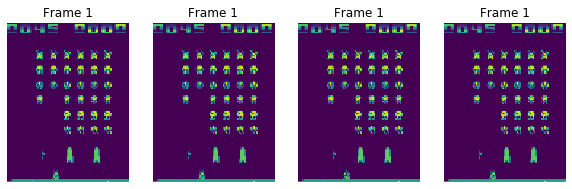

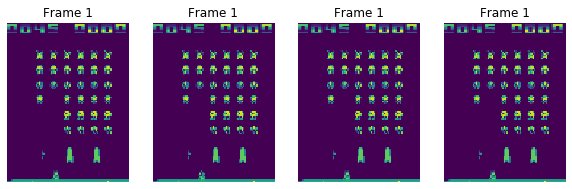

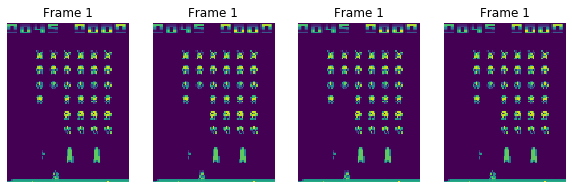

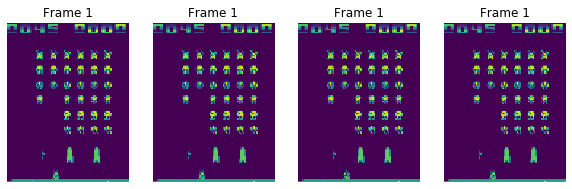

In [95]:
import itertools
deque_slice = deque(itertools.islice(memory.buffer, 600, 606))
for state, action, reward, state_next, done in deque_slice: 
    plot_frames([state[:,:,i] for i in range(0,4)], ['Frame ' + str(1) for i in range(0,4)])

### Training on the environment

In [14]:
# Re-Initialise memory for training
memory = Memory(MEMORY_SIZE)

# Store measurements
loss = []
reward_list = []
step_list = []
print_steps = 0
start_time = time()

 # Number of episodes to train 
N = 1   
for i in range(0, N):

    # Initialise state
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    reward_sum = 0
    
    # Initialise step oer episode
    step = 0
    done = False
    
    while not done:
        
        # Get action 
        action = act(state, EXPLORATION_RATE)

        # Take action
        state_next, reward, done, _ = env.step(action)
        
        # stops the episode by set max step
        if step > MAX_STEP:
            done = True
            print("Episode Done")

        # Append the next state
        state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)

        # Append to memory
        memory.add((state, action, reward, state_next, done))

        # Forward to next state
        state = state_next
        
        # accumulate rewards
        reward_sum += reward
        
        # accumilate steps
        step += 1
        print_steps += 1

        # Reduce the exploreation every step
        EXPLORATION_RATE *= EXPLORATION_DECAY
        EXPLORATION_RATE = max(EXPLORATION_MIN, EXPLORATION_RATE)
        
        ### Learning procedure begins ###
        # learn only when memory has be filled to batch size
        if len(memory.buffer) > BATCH_SIZE:
            history = model_fit(BATCH_SIZE)

            # store loss
            loss.append(history.history['loss'])
        ### Learning procedure ends ###
        
        # Print messge 
        if print_steps % 100 == 0:
            print("Afte {} steps, exploration rate: {:.4f}, reward: {}, Model loss: {:.4f}, Time elapsed: {:.4f}"\
                  .format(print_steps, EXPLORATION_RATE, reward_sum, history.history['loss'][0], time.time() - start_time))
            start_time = time()
            
    # Append values at the end of an episode
    step_list.append(step)
    reward_list.append(reward_sum)
    
    # print information at the end of the episode
    print("Episode {}, exploration rate: {:.4f}, final rewards: {}, final loss is {:.4f}"\
          .format(i+1, EXPLORATION_RATE, reward_sum, history.history['loss'][0]))

After step 100, exploration rate: 0.9048, reward: 5.0, Model loss: 0.07336506247520447
After step 200, exploration rate: 0.8186, reward: 35.0, Model loss: 0.6852014660835266
After step 300, exploration rate: 0.7407, reward: 85.0, Model loss: 2.2045936584472656
After step 400, exploration rate: 0.6702, reward: 85.0, Model loss: 0.8132551908493042
After step 500, exploration rate: 0.6064, reward: 85.0, Model loss: 0.6449185609817505
After step 600, exploration rate: 0.5486, reward: 140.0, Model loss: 0.05792766809463501
After step 700, exploration rate: 0.4964, reward: 140.0, Model loss: 0.015423493459820747
Episode 1, exploration rate: 0.4541, final rewards: 210.0, final loss is 1.0332


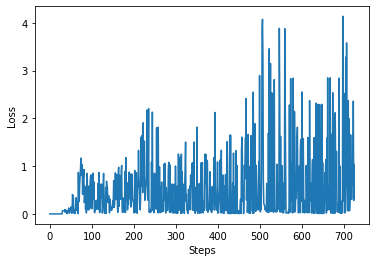

In [16]:
# plot loss
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.show()

In [17]:
   print("Afte {} steps, exploration rate: {:.4f}, reward: {}, Model loss: {:.4f}"\
                  .format(print_steps, EXPLORATION_RATE, reward_sum, history.history['loss'][0]))

Afte 789 steps, exploration rate: 0.4541, reward: 210.0, Model loss: 1.0332
